In [1]:
import numpy as np
import pandas as pd
import mne
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from lightgbm import LGBMClassifier
import lightgbm
import xgboost as xgb
from ipynb.fs.defs.yasa_model import calc_features, get_metrics
import joblib
from IPython.display import clear_output
plt.style.use('dark_background')
pd.options.display.precision = 10

In [2]:
joblib_file = 'lgbm_model_multichannel.pkl'
# model = joblib.load(joblib_file)
model = joblib.load('forest.pkl')
features_names = pd.read_csv('features.csv').columns.tolist()

In [3]:
####################
# MAIN PARAMETERS
####################

# # Bandpass filter
# freq_broad = (0.1, 500)
# # FFT & bandpower parameters
sr = 1000
# bands = [
#     (0.1, 4, 'delta'), (4, 8, 'theta'),
#     (8, 12, 'alpha'), (12, 16, 'sigma'), (16, 30, 'beta'),
#     (30, 75, 'gamma'), (75, 300, 'fast')
# ]

In [4]:
def format_raw_night(edf, channel):
    epochs = []
    window_size = int(sr / 4)
    if '-' in channel and 'REF' not in channel:
        chans = channel.split('-')
        raw = mne.io.read_raw_edf(edf).pick_channels(chans).resample(sr)
        mne.set_bipolar_reference(raw, chans[0], chans[1], ch_name=channel)
        raw_data = raw.get_data()[0]
    else:
        raw_data = mne.io.read_raw_edf(edf).pick_channels([channel]).resample(sr).get_data()[0]
    for i in range(0, len(raw_data), window_size):
        curr_block = raw_data[i: i  + window_size]
        if i + window_size < len(raw_data):
            epochs.append(curr_block)
    return np.array(epochs)

def get_y_bilateral(subj, channel):
    x_right = format_raw_night(f'C:\\UCLA\\{subj}_cz+bi_full_filtered.edf', 'R' + channel)
    feat_right = calc_features(x_right)
    y_right = model.predict(feat_right[features_names[1:]])

    x_left = format_raw_night(f'C:\\UCLA\\{subj}_cz+bi_full_filtered.edf', 'L' + channel)
    feat_left = calc_features(x_left)
    y_left = model.predict(feat_left[features_names[1:]])
    y_all = y_right + y_left
    y_all[y_all == 2] = 1
    return y_all

# TODO: debug again!
def get_y_bi_prob(subj, channel):
    x_right = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
    feat_right = calc_features(x_right)
    y_right_prob = model.predict_proba(feat_right[features_names[1:]]).T
    y_right = [1 if p > 0.85 else 0 for p in y_right_prob[1]]

    x_left = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
    feat_left = calc_features(x_left)
    y_left_prob = model.predict_proba(feat_left[features_names[1:]]).T
    y_left = [1 if p > 0.85 else 0 for p in y_left_prob[1]]
    y_all = y_right + y_left
    y_all[y_all == 2] = 1
    return y_all

In [32]:
def get_all_y_multi_channel():
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    side1_y = None
    y_all = np.empty(0)
    for subj in ['396', '398', '402', '406', '415', '416']:
        # for subj in ['398']:
        for channel in ['RAH1', 'LAH1']:
            if not (subj == '396' and channel == 'RAH1'):
                x = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
                features = calc_features(x)
                for neighbor in neighbors[channel[0]]:
                    x_neighbor = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', neighbor)
                    prefix = neighbor.replace(channel[0], '')
                    features_neighbor = calc_features(x_neighbor).add_prefix(f'{prefix}_')
                    features = pd.concat([features, features_neighbor], axis=1)

                # Here I have all features for one side
                if side1_y is None:
                    side1_y = model.predict(features[features_names[1:]])

        if subj == '396':
            y_all = np.concatenate((y_all, side1_y))
        else:
            side2_y = model.predict(features[features_names[1:]])
            y_bilateral = side1_y + side2_y
            y_bilateral[y_bilateral == 2] = 1
            y_all = np.concatenate((y_all, y_bilateral))

        side1_y = None

    return y_all

def get_all_y_multi_channel_side(side):
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    y_all = np.empty(0)
    for subj in ['396', '398', '402', '406', '415', '416']:
        channel = side + 'AH1'
        if not (subj == '396' and channel == 'RAH1'):
            x = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
            features = calc_features(x)
            for neighbor in neighbors[channel[0]]:
                x_neighbor = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', neighbor)
                prefix = neighbor.replace(channel[0], '')
                features_neighbor = calc_features(x_neighbor).add_prefix(f'{prefix}_')
                features = pd.concat([features, features_neighbor], axis=1)

            side1_y = model.predict(features[features_names[1:]])
            y_all = np.concatenate((y_all, side1_y))

    return y_all

def get_one_y_multi_channel_side(subj, side):
    neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    channel = side + 'AH1'
    if not (subj == '396' and channel == 'RAH1'):
        x = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', channel)
        features = calc_features(x)
        for neighbor in neighbors[channel[0]]:
            x_neighbor = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', neighbor)
            prefix = neighbor.replace(channel[0], '')
            features_neighbor = calc_features(x_neighbor).add_prefix(f'{prefix}_')
            features = pd.concat([features, features_neighbor], axis=1)

        side1_y = model.predict(features[features_names[1:]])

    return side1_y

def get_all_feat_eog(eog_num):
    feat_all = pd.DataFrame()
    for subj in ['396', '398', '402', '406', '415', '416']:
        x = format_raw_night(f'C:\\UCLA\\P{subj}_overnightData.edf', 'EOG' + eog_num)
        features = calc_features(x)
        feat_all = pd.concat([feat_all, features], axis=0)

    return feat_all

In [6]:
# y_406_bi = get_y_bilateral('406', 'AH')
# y_402_bi = get_y_bilateral('402', )

In [7]:
# y_406_bi_prob = get_y_bi_prob('406')
# y_402_bi_prob = get_y_bi_prob('402')

In [34]:
y_all_bi = get_all_y_multi_channel()
clear_output()

In [33]:
feat_all_eog1 = get_all_feat_eog('1')
feat_all_eog2 = get_all_feat_eog('2')
clear_output()

In [10]:
feat_eog2 = get_all_feat_eog('2')
feat_eog1 = get_all_feat_eog('1')
clear_output()

In [11]:
y_all_right = get_all_y_multi_channel_side('R')
y_all_left = get_all_y_multi_channel_side('L')
clear_output()

[12:29:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


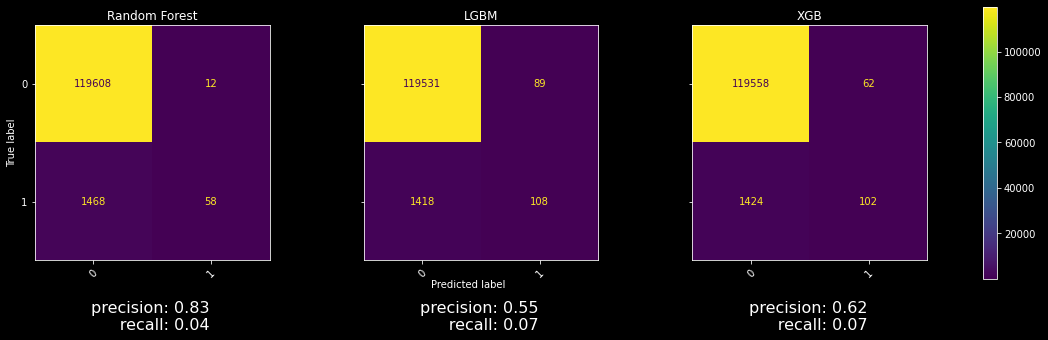

In [12]:
# EOG2 and right spikes, Forest spike prediction
X_train, X_test, y_train, y_test = train_test_split(feat_eog2, y_all_right, stratify=y_all_right, random_state=20)

classifiers_2_right = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
}

f, axes = plt.subplots(1, len(classifiers_2_right), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers_2_right.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    text = """precision: {0}
              recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

[12:40:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


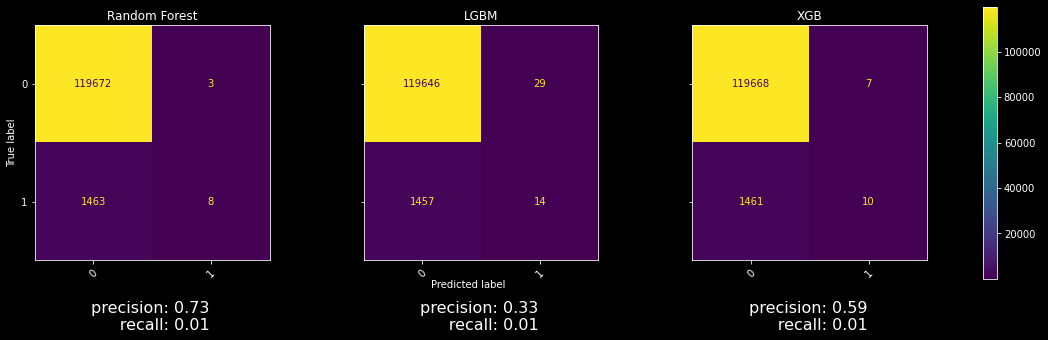

In [13]:
# EOG2 and left spikes, Forest spike prediction
X_train, X_test, y_train, y_test = train_test_split(feat_eog2, y_all_left, stratify=y_all_left, random_state=20)

classifiers_2_left = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
}

f, axes = plt.subplots(1, len(classifiers_2_left), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers_2_left.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    text = """precision: {0}
              recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

[12:49:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


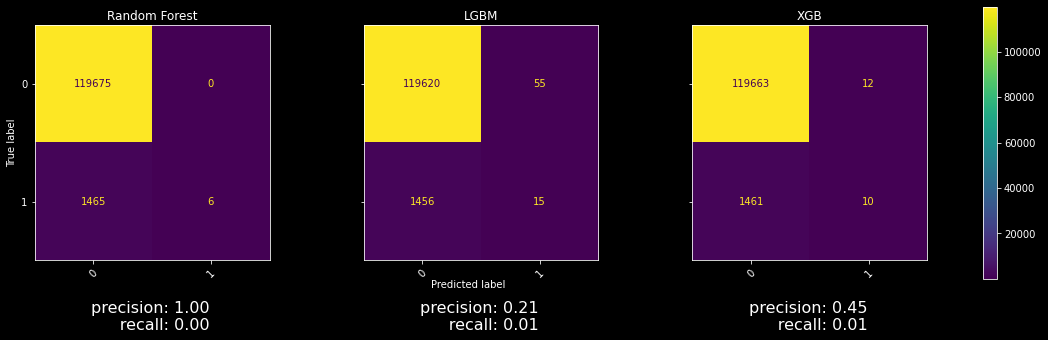

In [14]:
# EOG1 and left spikes, Forest spike prediction
X_train, X_test, y_train, y_test = train_test_split(feat_eog1, y_all_left, stratify=y_all_left, random_state=20)

classifiers_1_left = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
}

f, axes = plt.subplots(1, len(classifiers_1_left), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers_1_left.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    text = """precision: {0}
              recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

[13:01:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


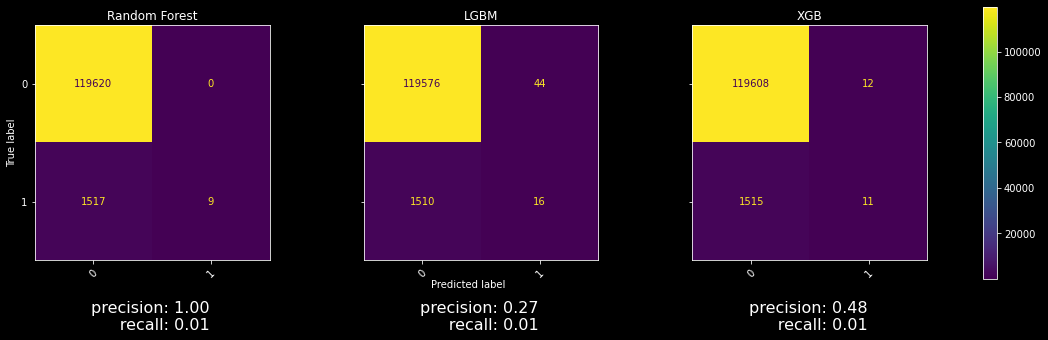

In [15]:
# EOG1 and right spikes, Forest spike prediction
X_train, X_test, y_train, y_test = train_test_split(feat_eog1, y_all_right, stratify=y_all_right, random_state=20)

classifiers_1_right = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
}

f, axes = plt.subplots(1, len(classifiers_1_right), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers_1_right.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    text = """precision: {0}
              recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [140]:
# plt.rcParams["figure.figsize"] = (15,7)
# lightgbm.plot_importance(jl_model)

In [33]:
feat_eog2

,std,iqr,skew,kurt,nzc,hmob,hcomp,theta,alpha,sigma,...,fast_pmin_norm,at_pmin_norm,gt_pmin_norm,ft_pmin_norm,ag_pmin_norm,af_pmin_norm,abspow_pmin_norm,perm_pmin_norm,higuchi_pmin_norm,petrosian_pmin_norm
epoch,,,,,,,,,,,,,,,,,,,,,
0,0.0000201169,0.0000392231,-0.0400115538,-1.5292258998,0,0.0514618836,5.4954295527,0.8748569969,0.1798491402,0.0208353643,...,0.1174111437,-0.2706485336,-0.0475228435,-0.0133598768,0.1515948159,0.2395833593,0.3443979292,0.0091253018,-0.0783975179,-0.0433883578
1,0.0000278503,0.0000505266,0.0777155304,-1.3171171555,0,0.0414747338,7.3742156405,0.9878851476,0.0646217569,0.0235803022,...,0.1832670428,-0.3098168437,-0.0276277040,0.0000811376,0.2781072716,0.3672962909,0.3174847593,-0.1738706789,-0.0046820031,-0.1343418704
2,0.0000286963,0.0000503895,-0.0383790465,-1.4866063712,0,0.0330131076,8.9004783240,0.8660544003,0.1621320518,0.0351991265,...,0.1635358665,-0.2986155138,-0.0485466877,0.0003898247,0.1203940187,0.2781624595,0.2915764096,-0.3569248660,-0.0684654618,-0.2480004605
3,0.0000171295,0.0000342861,-0.1376747718,-1.4204491919,0,0.0452069681,6.1189786562,0.8650961519,0.1001409080,0.0376624729,...,0.6254263790,-0.3034211949,0.0277941310,0.2044654435,0.2911636241,0.8492208473,0.1431535141,-0.1837179067,-0.1721556808,-0.1570690496
4,0.0000066531,0.0000087521,-0.7161534384,-0.3359864329,0,0.1190246520,2.7294585764,0.5301095917,0.0652813155,0.0294878954,...,1.2698993002,-0.2256488349,0.1533888483,0.5354832755,0.6334232189,1.5395610527,-0.0086054366,-0.0620426405,-0.1247934942,-0.1116809961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110165,0.0000048623,0.0000072715,-0.0888038169,-1.0386722417,4,0.0577111200,5.4570920251,0.6644850823,0.2034318750,0.0307952471,...,-0.0902106811,-0.0627316238,-0.1059641168,-0.0824365830,-0.1168776415,-0.0823870701,0.0011661950,0.3764904474,-0.4698533323,0.4497267358
110166,0.0000032326,0.0000041060,0.3108831585,-0.5597193827,6,0.0625751921,7.0362748723,0.5344753118,0.3231371980,0.0600966155,...,0.1585457442,-0.0259863933,-0.0909923608,-0.0098317320,-0.0617509004,0.2310074251,-0.0328306086,0.4756795636,-0.2492063720,0.6083821782
110167,0.0000046210,0.0000073434,0.8199042042,-0.6654370150,0,0.0350486345,14.8672581465,0.8482075290,0.1019735356,0.1762392199,...,0.4000932126,-0.2074909097,-0.0844443208,0.0438699040,-0.0056357138,0.5710108339,-0.0471551872,0.5885006056,-0.1161423222,0.8414405808


In [184]:
# x = format_raw_night('/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf', 'SEEG RAH1-REF')
# feat = calc_features(x)
# y = jl_model.predict(feat[features_names[1:]])
#
# x_eye = format_raw_night('/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf', 'EOG EOG2-REF')
# feat_eye = calc_features(x_eye)

# TODO: why its not the same length?
X_train, X_test, y_train, y_test = train_test_split(feat_eye, y_402_bi[:len(feat_eye)], stratify=y_402_bi[:len(feat_eye)], random_state=20)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    #     "Tree": DecisionTreeClassifier()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/rotemfalach/projects/venv/mmf_to_edf/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


[20:38:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[20:45:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/rotemfalach/projects/venv/mmf_to_edf/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


[17:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


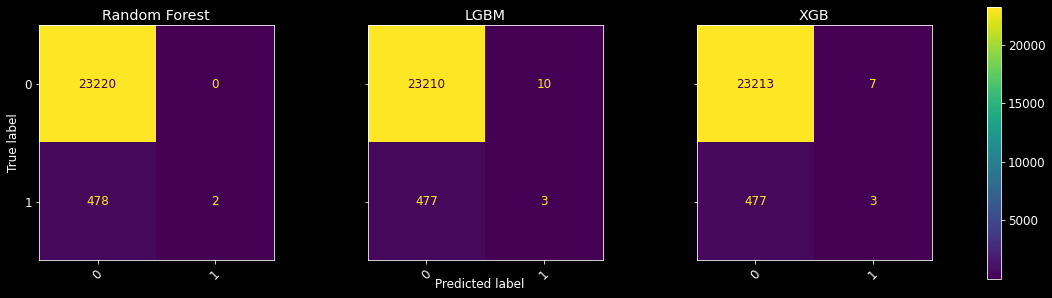

In [51]:
x_left = format_raw_night('/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf', 'SEEG LAH1-REF')
feat_left = calc_features(x_left)
y_left = jl_model.predict(feat_left[features_names[1:]])
y_all = y + y_left
y_all[y_all == 2] = 1

Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/rotemfalach/projects/venv/mmf_to_edf/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


array([0., 0., 0., ..., 0., 0., 0.])

In [53]:
y_all[y_all == 2] = 1

array([], dtype=float64)

Extracting EDF parameters from /Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P406_overnightData.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/rotemfalach/projects/venv/mmf_to_edf/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


[18:02:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


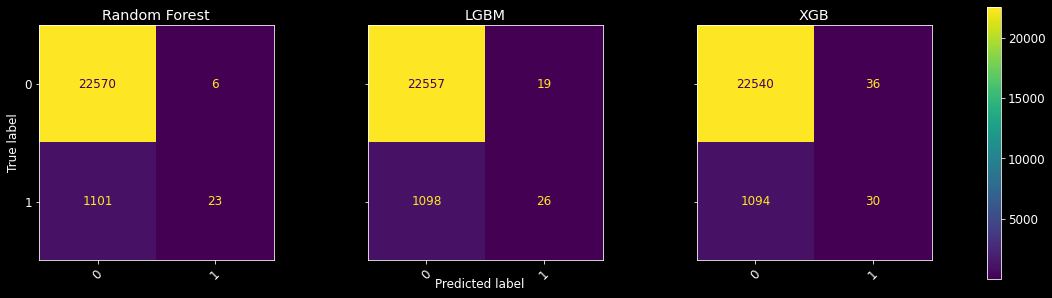

In [90]:
# union channels and subjects
def run_all():
    x_all = np.empty((0, 250))
    y_all = np.empty(0)
    feat_all = pd.DataFrame()
    features = pd.DataFrame()
    y_subj = None
    # create y array
    for subj in ['402', '406']:
        for channel in ['RAH1', 'LAH1']:
            x_curr = format_raw_night(f'/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P{subj}_overnightData.edf', f'SEEG {channel}-REF')
            feat_curr = calc_features(x_curr)
            y_curr = jl_model.predict(feat_curr[features_names[1:]])
            if y_subj is None:
                y_subj = np.zeros(len(y_curr))
            y_subj = y_subj + y_curr
            y_subj[y_subj == 2] = 1
        y_all = np.concatenate((y_all, y_subj))
        y_subj = None

    # create features for 2 eyes
    for subj in ['402', '406']:
        for channel in ['EOG1', 'EOG2']:
            x_curr = format_raw_night(f'/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/P{subj}_overnightData.edf', f'EOG {channel}-REF')
            x_all = np.concatenate((x_all, x_curr))
            feat_curr = calc_features(x_curr).add_prefix(f'{channel}_')
            features = pd.concat([features, feat_curr], axis=1)

        feat_all = pd.concat([feat_all, features], axis=0)
        features = pd.DataFrame()

    return x_all, feat_all, y_all

In [ ]:
x_all, feat_all, y_all = run_all()

[20:44:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


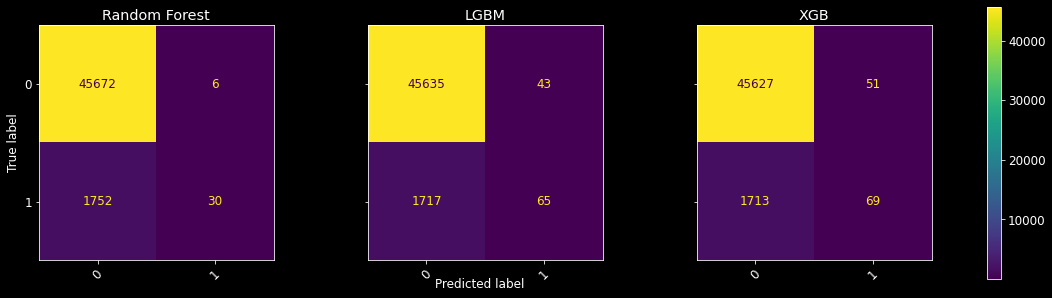

In [88]:
# subject 402 + 406
X_train, X_test, y_train, y_test = train_test_split(feat_all, y_all, stratify=y_all, random_state=20)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    #     "Tree": DecisionTreeClassifier()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
from sklearn.feature_selection import VarianceThreshold
x_all, feat_all, y_all = run_all()
all_col = feat_all.columns
selector = VarianceThreshold(.1)
selector.fit_transform(feat_all)
feat_all = feat_all[feat_all.columns[selector.get_support(indices=True)]]

# subject 402 + 406

X_train, X_test, y_train, y_test = train_test_split(feat_all, y_all, stratify=y_all, random_state=20)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
    #     "Tree": DecisionTreeClassifier()
}

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

<AxesSubplot:>

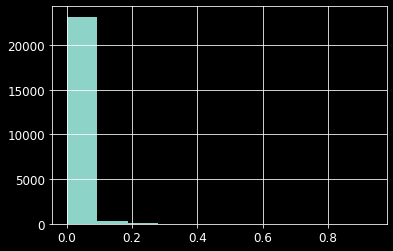

In [105]:
prob = pd.DataFrame(classifiers['LGBM'].predict_proba(X_test))
prob[prob[0] < 0.99].sort_values(by=prob.columns[1])[1].hist()


<AxesSubplot:>

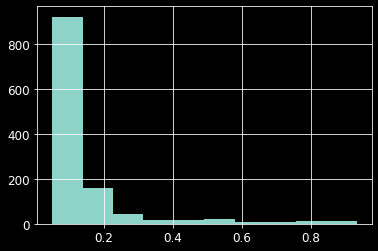

In [110]:
prob[prob[0] < 0.95].sort_values(by=prob.columns[1])[1].hist()

In [146]:
prob = pd.DataFrame(classifiers['LGBM'].predict_proba(X_test))
prob

,0,1
0,0.9792334993,0.0207665007
1,0.9899814096,0.0100185904
2,0.9936363417,0.0063636583
3,0.9986918195,0.0013081805
4,0.9736285091,0.0263714909
...,...,...
23695,0.9931237007,0.0068762993
23696,0.9890348297,0.0109651703
23697,0.9919490099,0.0080509901
23698,0.9973101149,0.0026898851


Reading EGI MFF Header from C:\PAT\AH8_SLEEP_20201125_155835.mff...
    Reading events ...
    Assembling measurement info ...


In [43]:
# health_raw.info['ch_names']

In [34]:
# health_raw = mne.io.read_raw_egi('/Users/rotemfalach/Downloads/MG4_sleep2_20190503_125004.mff')
health_raw = mne.io.read_raw_egi('C:\\PAT\\AH8_SLEEP_20201125_155835.mff')
# this is the  left set referenced to RM, while EOG referenced to LM
selected_set = [['E226', 'E46', 'E104', 'E35', 'E59', 'E116', 'E201'],
                ['EOG E1-LM', 'EOG E2-LM', 'LM', 'EEG F3-RM', 'EEG C3-RM', 'EEG O1-RM', 'RM']]
health_raw.pick_channels(selected_set[0]).resample(sr)
# order channels according to selected set, MNE default is alphabetical
health_raw.reorder_channels(selected_set[0])

# rename channels
health_raw.rename_channels({id: name for (id, name) in zip(selected_set[0], selected_set[1])})
# set EOG channels as MNE type "ecog" for re-refrencing
health_raw.set_channel_types({selected_set[1][i]: 'ecog' for i in range(2)})
# re-reference channels
health_raw.set_eeg_reference(ref_channels=[selected_set[1][2]], ch_type='ecog')
health_raw.set_channel_types({selected_set[1][i]: 'eog' for i in range(2)})
health_raw.drop_channels([selected_set[1][2], selected_set[1][6]])

Reading EGI MFF Header from C:\PAT\AH8_SLEEP_20201125_155835.mff...
    Reading events ...
    Assembling measurement info ...
Applying a custom ECoG reference.


<RawMff | signal1.bin, 5 x 9456971 (9457.0 s), ~360.9 MB, data loaded>

In [178]:
health_raw

In [46]:
epochs = []
health_data = health_raw.pick_channels(['EOG E2-LM']).get_data()[0]
window_size = 250
for i in range(0, len(health_data), window_size):
    curr_block = health_data[i: i  + window_size]
    if i + window_size < len(health_data):
        epochs.append(curr_block)
epochs = np.array(epochs)

feat_healthy_eye = calc_features(epochs)
y_healthy_pred = classifiers['LGBM'].predict(feat_healthy_eye)

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


ValueError: Number of features of the model must match the input. Model n_features_ is 66 and input n_features is 63

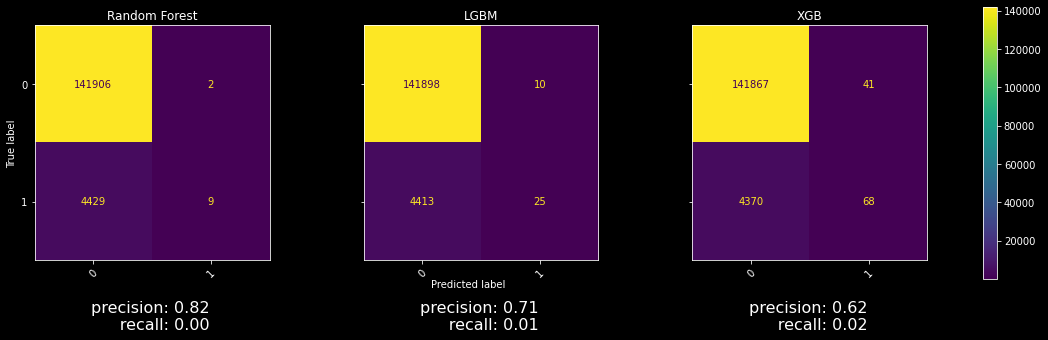

In [51]:

f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers_all.items()):
    y_pred = classifier.predict_proba(X_test).T
    cf_matrix = confusion_matrix(y_test, [p > 0.80 for p in y_pred[1]])
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    text = """precision: {0}
              recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
x = format_raw_night(f'C:\\UCLA\\P396_overnightData.edf', 'EOG1')
feat_eog1_396 = calc_features(x)
x = format_raw_night(f'C:\\UCLA\\P396_overnightData.edf', 'EOG2')
feat_eog2_396 = calc_features(x)

In [ ]:
y_left_396 = get_one_y_multi_channel_side('396', 'L')

In [26]:
def plot_classifiers_396_1(classifiers):
    f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

    for i, (key, classifier) in enumerate(classifiers.items()):
        y_pred = classifier.predict(feat_eog1_396)
        cf_matrix = confusion_matrix(y_left_396, y_pred)
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        text = """precision: {0}
                  recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
        axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')

    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)


    f.colorbar(disp.im_, ax=axes)
    plt.show()

def plot_classifiers_396_2(classifiers):
    f, axes = plt.subplots(1, len(classifiers), figsize=(20, 5), sharey='row')

    for i, (key, classifier) in enumerate(classifiers.items()):
        y_pred = classifier.predict(feat_eog2_396)
        cf_matrix = confusion_matrix(y_left_396, y_pred)
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        text = """precision: {0}
                  recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
        axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')

    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)


    f.colorbar(disp.im_, ax=axes)
    plt.show()

In [ ]:
# i_pred = X_test[y_pred == 1].sort_values(by='epoch').index.tolist()
# i_pred.sort()
# for i in i_pred[:20]:
#     fig, axs = plt.subplots(3, figsize=(4, 4))
#     axs[0].set_title(i)
#     pred_view = np.concatenate(x_AH[i - 2: i + 3])
#     axs[0].plot(pred_view)
#     axs[0].plot(range(500, 750), x_AH[i], c='red')
#     pred_view = np.concatenate(x_bi[i - 2: i + 3])
#     axs[2].plot(pred_view)
#     axs[2].plot(range(500, 750), x_bi[i], c='black')
#     pred_view = np.concatenate(x_A[i - 2: i + 3])
#     axs[1].plot(pred_view)
#     axs[1].plot(range(500, 750), x_A[i], c='green')

[15:49:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


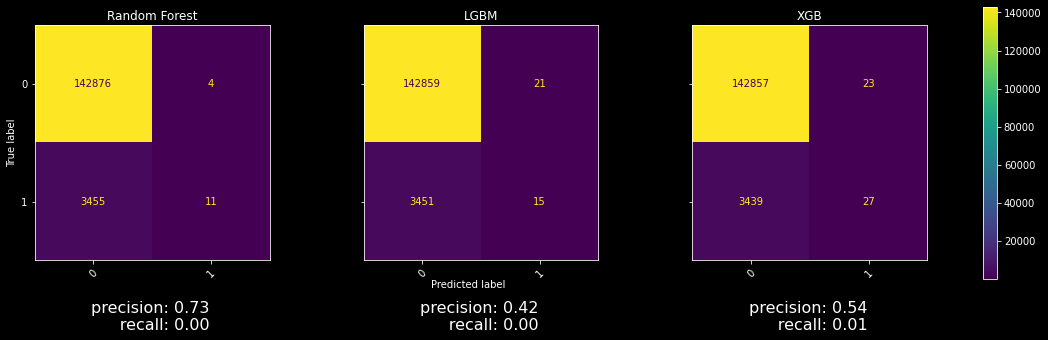

In [35]:
# EOG1 and all spikes, Forest spike prediction
X_train, X_test, y_train, y_test = train_test_split(feat_all_eog1, y_all_bi, stratify=y_all_bi, random_state=20)

classifiers_1_all = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
}

f, axes = plt.subplots(1, len(classifiers_2_right), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers_2_right.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    text = """precision: {0}
              recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

[16:01:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


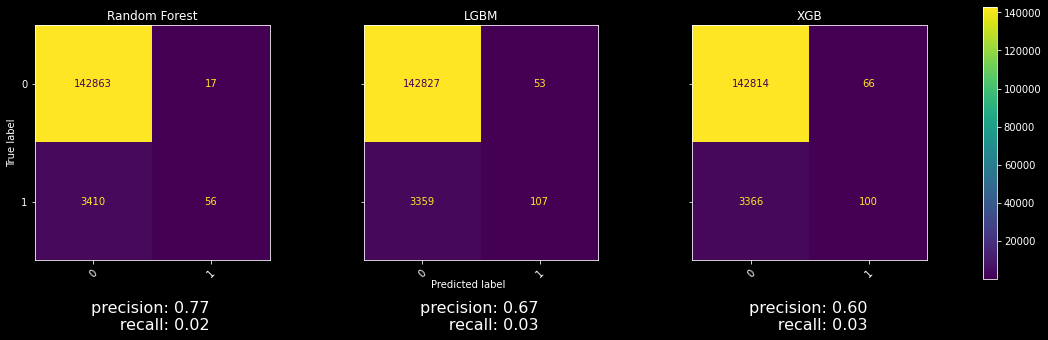

In [36]:
# EOG2 and all spikes, Forest spike prediction
X_train, X_test, y_train, y_test = train_test_split(feat_all_eog2, y_all_bi, stratify=y_all_bi, random_state=20)

classifiers_2_all = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
    "XGB": xgb.XGBClassifier(objective="multi:softmax", num_class=2, use_label_encoder=False),
}

f, axes = plt.subplots(1, len(classifiers_2_right), figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers_2_right.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    text = """precision: {0}
              recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()